# Basic evolution of signaling and receiving strategies

Last updated 7/12/20

To create the `full.csv` datasets used below, enter either the disliking or receptivity directories and run the following commands. The filename `part-8d02...` is auto-generated and specific to the particular output generated on the last run. Use tab-complete to get one of the part files you have for your specific run. The first line creates a new file, `full.csv`, with only the CSV header, and the second line concatenates all CSV lines but the headers into `full.csv`.

```sh
head -n1 part-5d84e99f-18e3-4c12-b273-b13ceb838ce4.csv > full.csv
tail -q -n+2 part-*.csv >> full.csv
```

## Heatmaps

This reads in the different `full.csv` files that correspond to different values of adoption curve steepness, $\beta$, also called "learning beta". It is the steepness of the logistic function used to calculate the probability the learner will adopt the teacher's strategy. The probability is written

$$
\Pr(i \text{ adopts } j) = \frac{1}{1 + e^{-\beta(\pi_j - \pi_i)}}
$$

where $\pi_i$ is agent $i$'s gross interaction payoffs.

There are three values tested $\beta=1,~2,~10$. In this section I check that there are the correct number of trials (100) per parameter setting. Each heatmap value is the average over 100 trials.

In [2]:
import sys
sys.path.append('..')

import pandas as pd

FIGDIR = '../../papers/idsig/Figures'

from id_signaling.figures import *

In [3]:
# for beta in betas:
    
# disliking = dislikings[beta]

disliking = pd.read_csv(f'../data/basic/disliking/full.csv')
receptivity = pd.read_csv(f'../data/basic/receptivity/full.csv')

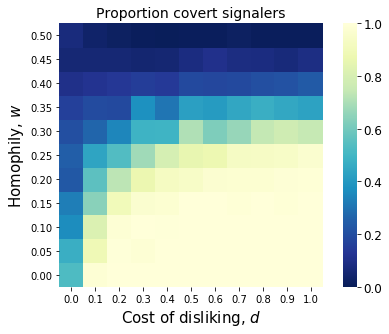

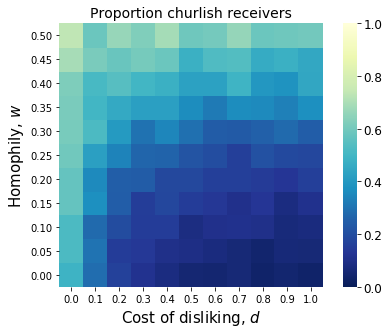

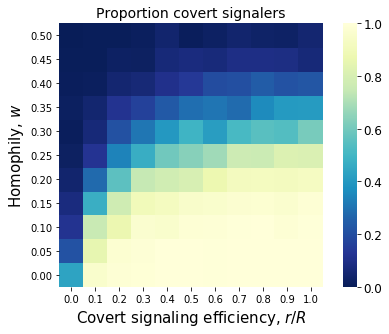

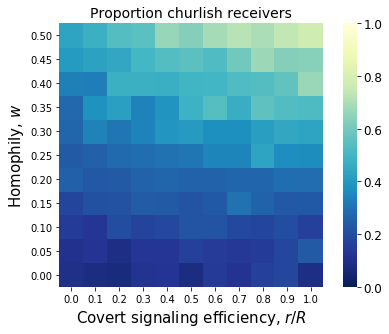

In [14]:
heatmap(disliking, experiment='disliking')
plt.title(f'Proportion covert signalers', size=14)
plt.savefig(f'../../papers/idsig/Figures/basic_disliking_signaling.pdf')

heatmap(disliking, experiment='disliking', strategy='receiving')
plt.title(f'Proportion churlish receivers', size=14)
plt.savefig(f'../../papers/idsig/Figures/basic_disliking_receiving.pdf')


heatmap(receptivity, experiment='receptivity')
plt.title(f'Proportion covert signalers', size=14)
plt.savefig(f'../../papers/idsig/Figures/basic_receptivity_signaling.pdf')

heatmap(receptivity, experiment='receptivity', strategy='receiving')
plt.title(f'Proportion churlish receivers', size=14)
plt.savefig(f'../../papers/idsig/Figures/basic_receptivity_receiving.pdf')

## Regressions

Here we want to understand the how covert signaling evolves with churlish receiving. To do this we use hex bins to make a 2D histogram and present a linear regression on top of that. We expect to see a positive linear relationship between covert signaling prevalence ($\rho_{cov}$) and chulrish receiving prevalence ($\rho_{ch}$).

Each of the two experiments, one varying disliking and one varying covert signaling efficiency, has four relevant outcome variables, the prevalence of covert or overt signaling and the prevalence of churlish or generous receiving. Although it seems we could just plot covert signaling versus generous receiving, for which we hypothesize a positive correlation, we also plot covert signaling against churlish receiving, which I believe
will have the same magnitude slope but negative.

This needs to be done for both the disliking and receptivity experiments.

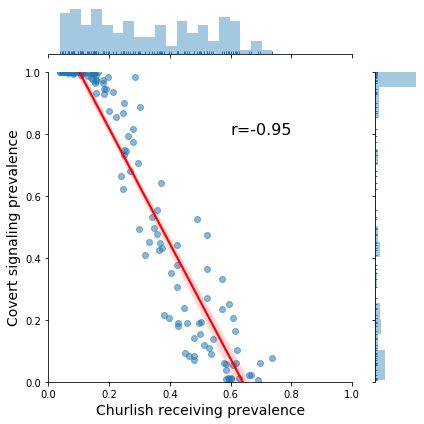

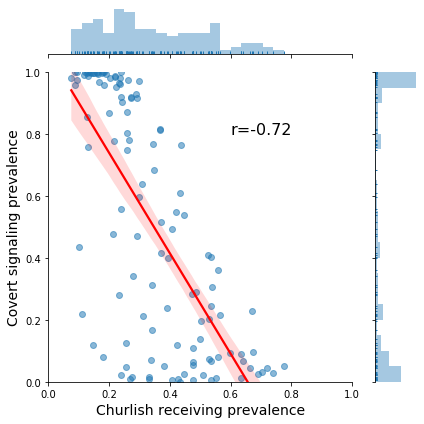

In [6]:
def plot_correlation(df, n_timesteps=100):
    '''
    Calculates the mean over trials for different parameter combinations 
    at the final time step and 
    '''
    try:
        gb = df[df.timestep == n_timesteps].groupby(['homophily', 'disliking'])
    except:
        gb = df[df.timestep == n_timesteps].groupby(['homophily', 'receptivity'])
            
    prop_churlish = np.array(gb['prop_churlish'].mean())
    plot_df = pd.DataFrame(dict(
        prop_churlish=prop_churlish,
        prop_generous=1 - prop_churlish,
        prop_covert=np.array(gb['prop_covert'].mean())
    ))

    # g = sns.jointplot(x=prop_churlish, y=prop_covert, kind='hex')
    # plt.plot(prop_churlish, prop_covert, 'o')
    # plt.title('')

    from scipy import stats
    x = plot_df.prop_churlish
    y = plot_df.prop_covert
    pearson_coef, p_val = stats.pearsonr(x, y)
    

    g = sns.jointplot(x, y, alpha=0.525, marginal_kws=dict(bins=20, rug=True))
    ax = g.ax_joint
    sns.regplot(x, y, line_kws=dict(color='r'), ax=ax, scatter=False)
    #                 scatter_kws=dict(lw=0, s=45, alpha=0.525))
    ax.set_ylabel('Covert signaling prevalence', size=14)
    ax.set_xlabel('Churlish receiving prevalence', size=14)

    pearson_coef, p_value = stats.pearsonr(x, y) #define the columns to perform calculations on

    ax.text(s=f'r={pearson_coef:.2f}', x=0.6, y=0.8, size=16)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    
    
plot_correlation(disliking)
plt.savefig(f'{FIGDIR}/basic_disliking_correlation.pdf')

plot_correlation(receptivity)
plt.savefig(f'{FIGDIR}/basic_receptivity_correlation.pdf')

## Further analyses: time series and final time step histograms

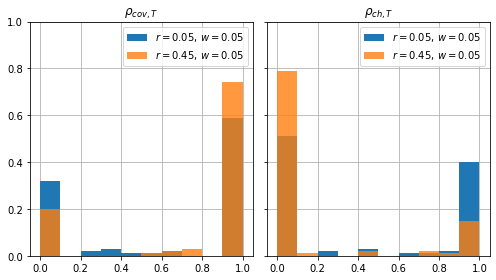

In [37]:
# Specify two dataframes for detailed look at histograms and time series.
disliking = dislikings['10.0']
receptivity = receptivities['10.0']
dis_rec = 0.05
homophily = 0.05

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(7, 4))

df = disliking
pre = mean_final_cov_prop = df[
    (df.timestep == 500) &
    (df.disliking == dis_rec) &
    (df.homophily == homophily)
]
prop_cov = pre.prop_covert
L = len(prop_cov)
assert L == 100
bins = 10
pre.prop_covert.hist(weights=np.ones(L)/L, label=f'$r={dis_rec}$, $w={homophily}$', 
                     ax=axes[0], bins=bins)
pre.prop_churlish.hist(weights=np.ones(L)/L, label=f'$r={dis_rec}$, $w={homophily}$', 
                       ax=axes[1], bins=bins)

dis_rec = 0.45
homophily = 0.05

df = disliking
pre = mean_final_cov_prop = df[
    (df.timestep == 500) &
    (df.disliking == dis_rec) &
    (df.homophily == homophily)
]
prop_cov = pre.prop_covert
L = len(prop_cov)

assert L == 100

pre.prop_covert.hist(weights=np.ones(L)/L, label=f'$r={dis_rec}$, $w={homophily}$', 
                     alpha=0.8, ax=axes[0], bins=bins)
pre.prop_churlish.hist(weights=np.ones(L)/L, label=f'$r={dis_rec}$, $w={homophily}$', 
                     alpha=0.8, ax=axes[1], bins=bins)

axes[0].set_title(r'$\rho_{cov,T}$')
axes[1].set_title(r'$\rho_{ch,T}$')

for ax in axes:
    ax.legend()
    ax.set_axisbelow(True)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 1.0)

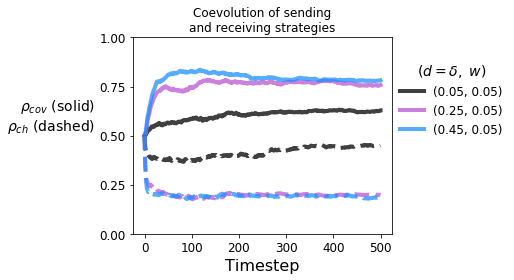

In [38]:
colors = ['black',  'mediumorchid', 'dodgerblue','darkorange', 'purple', 'black']
param_vals=[0.05, 0.25, 0.45]
hvals = [0.05]
ax = plot_evolution(disliking, experiment='disliking', exp_param_vals=param_vals, 
               homophily_vals=hvals, figsize=(7.25, 4), color=colors)
plt.ylim(0, 1)

plot_evolution(disliking, experiment='disliking', strategy='receiving', exp_param_vals=param_vals, 
               homophily_vals=hvals, figsize=(7.25, 4), ls='--', ax=ax, color=colors)
plt.ylim(0, 1)

plt.title('Coevolution of sending\nand receiving strategies')
plt.ylabel(r'$\rho_{cov}$ (solid)' '\n' r'$\rho_{ch}$ (dashed)', 
           rotation=0, ha='right', size=14)
plt.yticks(np.arange(0, 1.01, 0.25));
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:3], labels[:3], bbox_to_anchor=(1.01, 0.9), loc='upper left', 
          ncol=1, title=r'$(d=\delta,~w)$', borderaxespad=0, frameon=False, prop={'size': 12}, 
          title_fontsize=14)

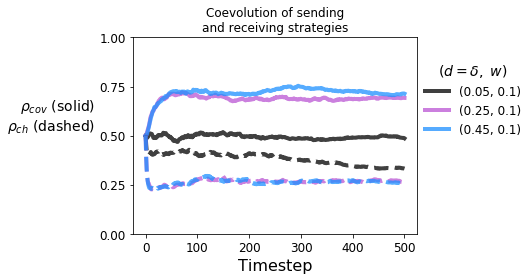

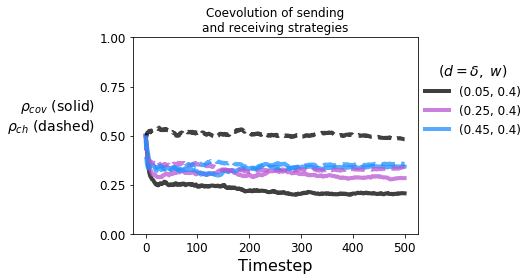

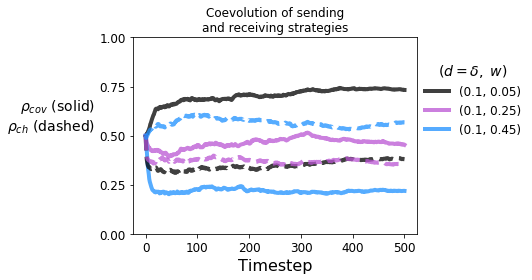

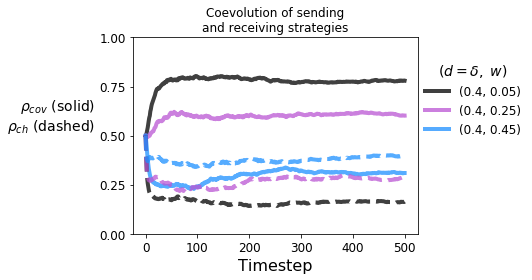

In [41]:
from id_signaling.figures import plot_coevolution


param_vals=[0.05, 0.25, 0.45]
hvals = [0.1]
plot_coevolution(disliking, 'disliking', param_vals, hvals)  # , savefig_path='reports/Figures/disliking_evo_w=0p1.pdf')

param_vals=[0.05, 0.25, 0.45]
hvals = [0.4]
plot_coevolution(disliking, 'disliking', param_vals, hvals)  # , savefig_path='reports/Figures/disliking_evo_w=0p4.pdf')


hvals = [0.05, 0.25, 0.45]
param_vals = [0.1]
plot_coevolution(disliking, 'disliking', param_vals, hvals)  #, savefig_path='reports/Figures/disliking_evo_d=0p1.pdf')

hvals = [0.05, 0.25, 0.45]
param_vals = [0.4]
plot_coevolution(disliking, 'disliking', param_vals, hvals)  #, savefig_path='reports/Figures/disliking_evo_d=0p4.pdf')

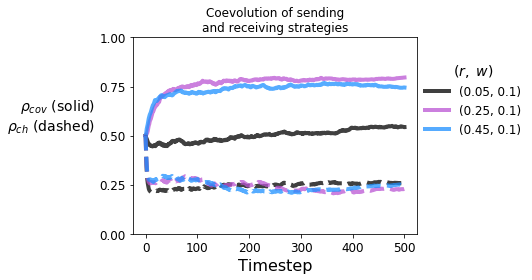

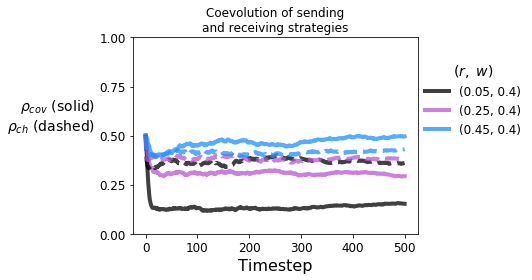

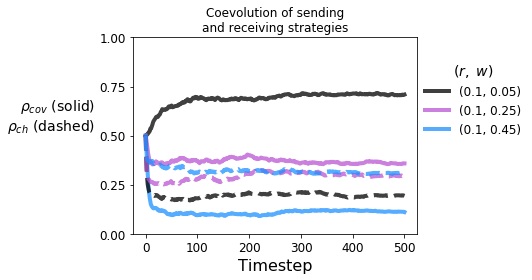

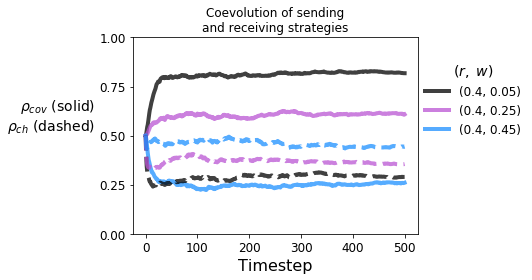

In [43]:

param_vals=[0.05, 0.25, 0.45]
hvals = [0.1]
plot_coevolution(receptivity, 'receptivity', param_vals, hvals) # , savefig_path='reports/Figures/receptivity_evo_w=0p1.pdf')

param_vals=[0.05, 0.25, 0.45]
hvals = [0.4]
plot_coevolution(receptivity, 'receptivity', param_vals, hvals) # , savefig_path='reports/Figures/receptivity_evo_w=0p4.pdf')


hvals = [0.05, 0.25, 0.45]
param_vals = [0.1]
plot_coevolution(receptivity, 'receptivity', param_vals, hvals) # , savefig_path='reports/Figures/receptivity_evo_r=0p1.pdf')

hvals = [0.05, 0.25, 0.45]
param_vals = [0.4]
plot_coevolution(receptivity, 'receptivity', param_vals, hvals) # , savefig_path='reports/Figures/receptivity_evo_r=0p4.pdf')

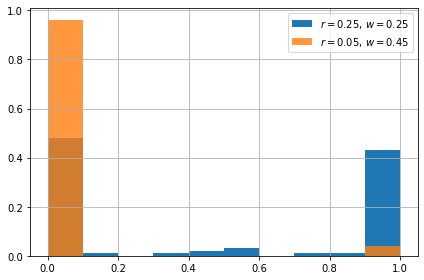

In [44]:
dis_rec = 0.25
homophily = 0.25

df = receptivity
pre = mean_final_cov_prop = df[
    (df.timestep == 500) &
    (df.receptivity == dis_rec) &
    (df.homophily == homophily)
]
prop_cov = pre.prop_covert
L = len(prop_cov)
assert L == 100
pre.prop_covert.hist(weights=np.ones(L)/L, label=f'$r={dis_rec}$, $w={homophily}$')

dis_rec = 0.05
homophily = 0.45

df = receptivity
pre = mean_final_cov_prop = df[
    (df.timestep == 500) &
    (df.receptivity == dis_rec) &
    (df.homophily == homophily)
]
prop_cov = pre.prop_covert
L = len(prop_cov)
assert L == 100
pre.prop_covert.hist(weights=np.ones(L)/L, label=f'$r={dis_rec}$, $w={homophily}$', alpha=0.8)

plt.legend()

# Checking performance with different values of $\beta$

Current runs with n interactions = 10 is in Basic_BetaComparisons folder. Will need to update with 100-interaction runs later.